# Optimization

## Optimization via Gradient Descent

In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def backtracking(x, f, grad_f):
    """
    inputs:
    x: ndarray. The actual iterate x_k.
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).

    outputs:
    alpha: float. The value of alpha that satisfies the backtracking condition.
    """
    alpha = 1
    c = 0.8
    tau = 0.25

    n = 0
    if grad_f(x).shape != (1,1):
        n = norm(grad_f(x),2)
    else:
        n = np.abs(grad_f(x))

    # Cheking the Sufficent Decrease Condition (Armijo Condition)
    # f(x - alpha*grad_f(x)) <= f(x) - c*alpha*(grad_f(x)^T)*grad_f(x)
    # second Wolf condition (Curvature condition) is automatically satisfied
    while f((x - (alpha * grad_f(x)).T).flatten()) > f(x) - c * alpha * (n ** 2):
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def GD(f, grad_f, x0=0, maxit=1000, tolf=1e-5, tolx=1e-5, back_flag=False, alpha=0.1):
    """
    Gradient Descent method

    inputs:
    f: function. Function to be minimized(optimize).
    grad_f: function. Gradient of f.
    x0: ndarray. Initial guess.
    maxit: int. Maximum number of iterations.
    tolf: float. Tolerance for the of the algorithm. Convergence is reached when the norm(grad_f(x_k),2) < tolf*norm(grad_f(x0),2).
    tolx: float. Tolerance for the x value. Convergence is reached when norm(x_k - x_k-1,2) < tolx.
    back_flag: bool. If True, the algorithm uses backtracking to update alpha.
    alpha: float. Value of alpha. Only used if back_flag is False.

    outputs:
    x: ndarray. Array that contains the value of x for each iterate.
    k: int. Number of iterations needed to converge.
    f_val: ndarray. Array of the value of each f(x).
    grads: ndarray. Array of gradient values.
    err: ndarray. Array of error values (normalize gradient).
    converge: bool. True if the method converges.
    """
    # Trashold to check if the values are diverging
    div_chek = 1e10

    # Calculate the initial alpha value
    if back_flag:
        alpha = backtracking(x0, f, grad_f)

    # Setting the initial values
    x, f_val, grads, err = [], [], [], []
    x.append(x0)
    f_val.append(f(x0))
    grads.append(grad_f(x0))
    err.append(norm(grads[0],2))

    for k in range(1,maxit):
        # Update the x value iterativly and saves the last value
        x.append(x[k-1] - (alpha*grad_f(x[k-1]).flatten()))
        if (x[k] > div_chek).any():
            message = "Diverging"
            # print(message)
            return x,k,f_val,grads,err,False,message
        
        # Update alpha with backtracking
        if back_flag:
            alpha = backtracking(x[k], f, grad_f, )
        
        # Adding the values to be returned
        f_val.append(f(x[k]))
        grads.append(grad_f(x[k]))
        err.append(norm(grads[k],2))
        
        if (grads[k] > div_chek).any():
            message = "Diverging"
            # print(message)
            return x,k,f_val,grads,err,False,message
        

        # Check the stop condition
        if norm(grad_f(x[k]),2) < tolf * norm(grad_f(x0),2):
            message = "Stop for f tolerance"
            # print(message)
            return x,k,f_val,grads,err,True,message
        if norm(x[k] - x[k-1],2) < tolx:
            message = "Stop for x tolerance"
            # print(message)
            return x,k,f_val,grads,err,True,message
        
    message = "Reached maxit"
    # print(message)
    return x,maxit,f_val,grads,err,True,message

In [3]:
def exercise_f(f, grad_f, x0=None, true_sol=None, dimensions=2, alphas=[0.001,0.01,0.1,0.2], tolf=1e-5, tolx=1e-5):
    # Fixed parameters
    if x0 is None:
        x0 = np.zeros((dimensions, )).T
    kmax = 100

    # Compute the solution with fixed alpha values
    x, k, fval, grads, err, converge, messages = [], [], [], [], [], [], []
    for alpha in alphas:
        x_i, k_i, fval_i, grads_i, err_i, converge_i, message_i = GD(f,grad_f,x0,maxit=kmax, tolf=tolf, tolx=tolx, back_flag=False, alpha=alpha)
        x.append(x_i)
        k.append(k_i)
        fval.append(fval_i)
        grads.append(grads_i)
        err.append(err_i)
        converge.append(converge_i)
        messages.append(message_i)

    # Compute the solution with backtracking
    x_back,k_back,fval_back,grads_back,err_back, converge_back, message_back = GD(f,grad_f,x0,maxit=kmax, tolf=tolf, tolx=tolx, back_flag=True, alpha=alpha)

    # Plots
    fig = plt.figure(figsize=(12,6))

    # Plot the norm of the gradient
    plt.subplot(1,2,1)
    plt.title("Norm of the gradient")
    for (i,alpha) in enumerate(alphas): 
        if converge[i]:
            line, = plt.plot(err[i],label=r"$\alpha$={}, $k$={}".format(alpha,k[i]))
            index_1_5 = len(err[i]) // 5
            x_position = index_1_5
            y_position = err[i][index_1_5]
            plt.text(x_position, y_position+(i/5), messages[i], fontsize=12, color=line.get_color())
    line, = plt.plot(err_back,label=r"$\alpha$=back, $k$={}".format(k_back))
    index_1_5 = len(err_back) // 5
    x_position = index_1_5
    y_position = err_back[index_1_5]
    plt.text(x_position, y_position, message_back, fontsize=12, color=line.get_color())
    plt.xlabel(r"$k$")
    plt.ylabel("$\\| \\nabla f(x^k) \\|_2$")
    plt.legend(loc="upper right")
    
    if true_sol is not None:
        plt.subplot(1,2,2)
        plt.title("Distance from true solution")
        for (i,alpha) in enumerate(alphas): 
            if converge[i]:
                plt.plot(norm(x[i] - true_sol.T,2,axis=1),label=r"$\alpha$={}, $k$={}".format(alpha,k[i]))
        plt.plot(norm(x_back - true_sol.T,2,axis=1),label=r"$\alpha$=back, $k$={}".format(k_back))
        plt.xlabel(r"$k$")
        plt.ylabel(r"$\left\| x_i - \mathbf{true\_sol}^T \right\|_2$")
        plt.legend(loc="upper right")
    
    plt.show()

### **FUNCTION 1**

$f : R^2 → R$ such that

$$f (x_1, x_2) = (x_1 − 3)^2 + (x_2 − 1)^2$$
for which the true optimum is $x^* = (3, 1)^T$ .

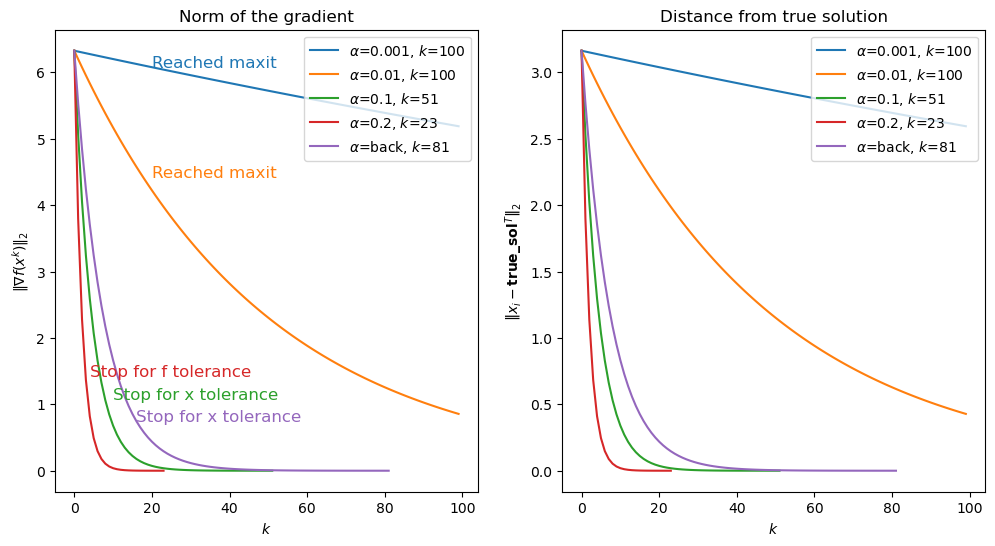

In [4]:

def f(x):
    return (x[0] - 3)**2 + (x[1] - 1)**2

def grad_f(x):
    x = x.flatten()
    return np.array([[2*(x[0] - 3)],
                     [2*(x[1] - 1)]])

true_sol = np.array([[3],[1]])
x0 = np.array([0,0])
exercise_f(f,grad_f,x0=x0,true_sol=true_sol) 

### **Function 2**

$f : \mathbb{R}^2 → \mathbb{R}$ such that:

$$f (x_1, x_2) = 10(x_1 − 1)^2 + (x_2 − 2)^2$$

for which the true optimum is $x^∗ = (1, 2)^T$.

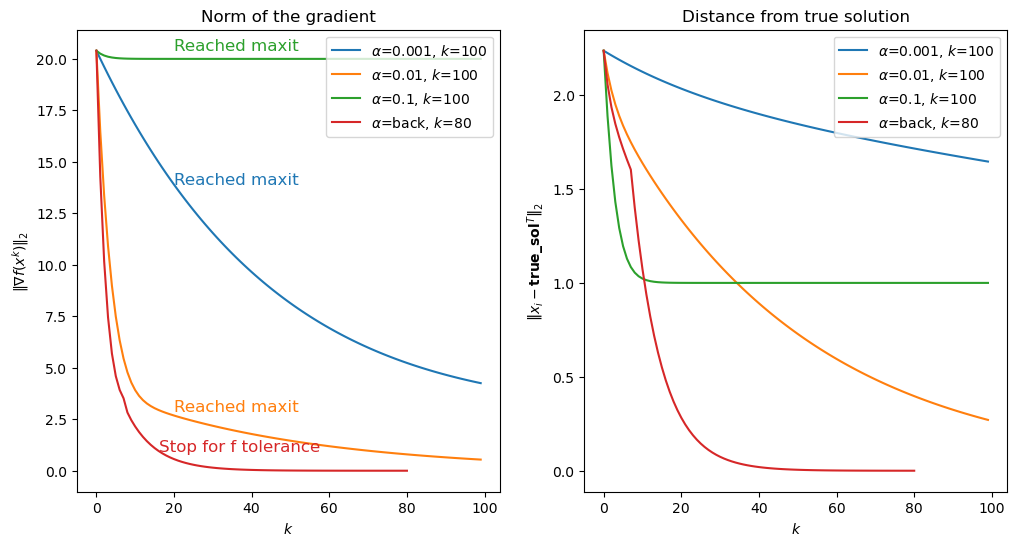

In [5]:
def f(x):
    return 10*(x[0] - 1)**2 + (x[1] - 2)**2

def grad_f(x):
    x = x.flatten()
    return np.array([[20*(x[0] - 1)],
                     [2*(x[1] - 2)]])

true_sol = np.array([[1],[2]])
x0 = np.array([0,0])
exercise_f(f,grad_f,x0=x0,true_sol=true_sol)

GD with $\alpha = 0.1$ doesn't find the solution and gets stuck after a few iterations.

----------------

### **Function 3**

$f : \mathbb{R}^n → \mathbb{R}$ such that:

$$ f (x) = \frac{1}{2} \lVert Ax − b \rVert _2^2$$

where $A \in \mathbb{R}^{n \times n}$ is the Vandermonde matrix associated with the vector $v \in \mathbb{R}^n$ that contains $n$ equispaced values in the interval $[0, 1]$, and $b \in \mathbb{R}^n$ is computed by first setting $x_{true} =
(1, 1, \dots , 1)^T$ and then $b = A x_{true}$. Try for different values of $n$ (e.g. $n = 5, 10, 15, \dots$ ).

n =  5


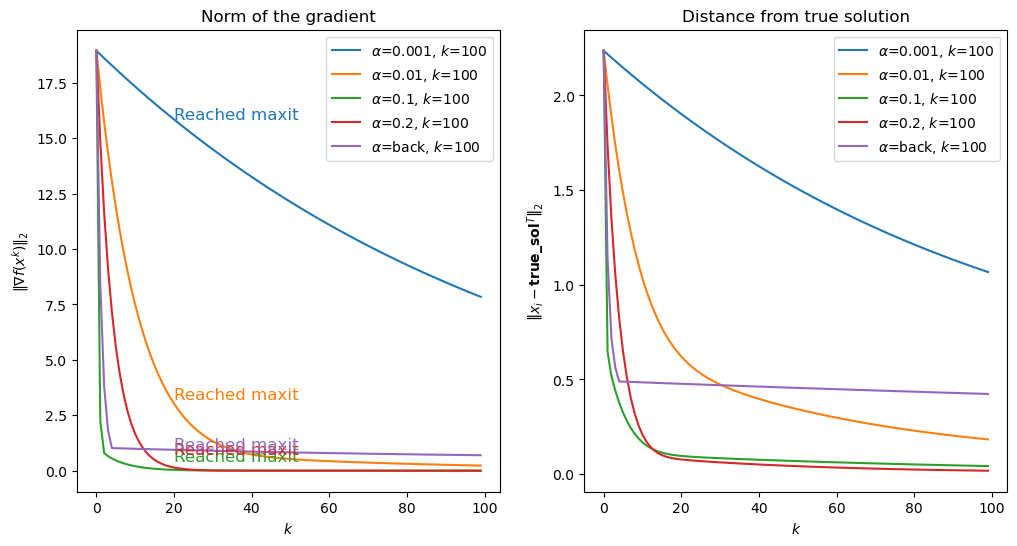

n =  10


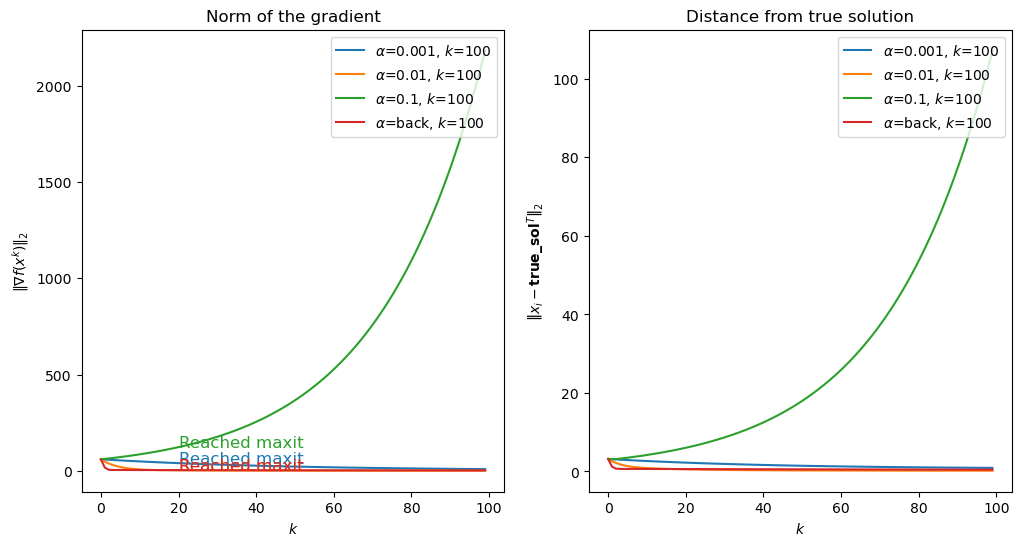

n =  20


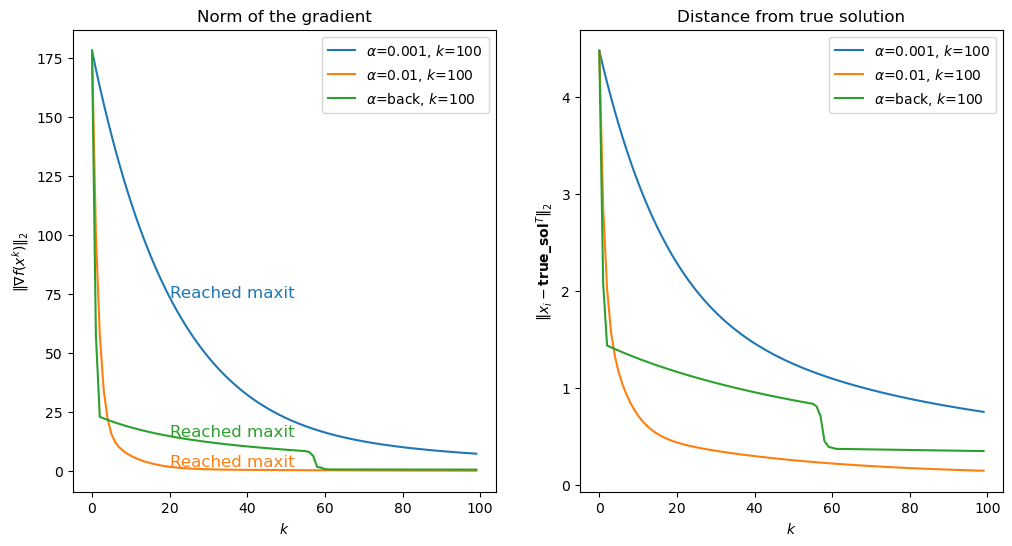

n =  50


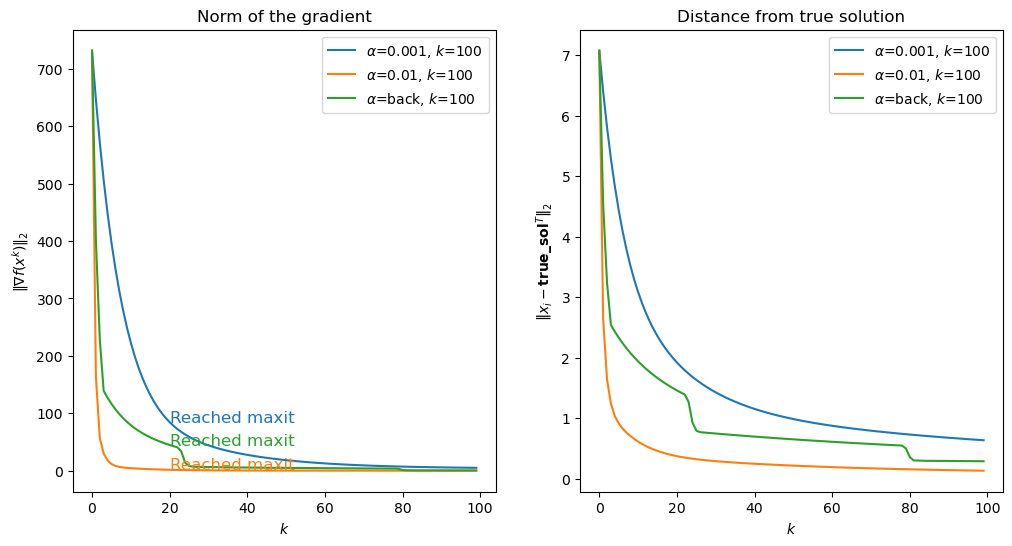

n =  100


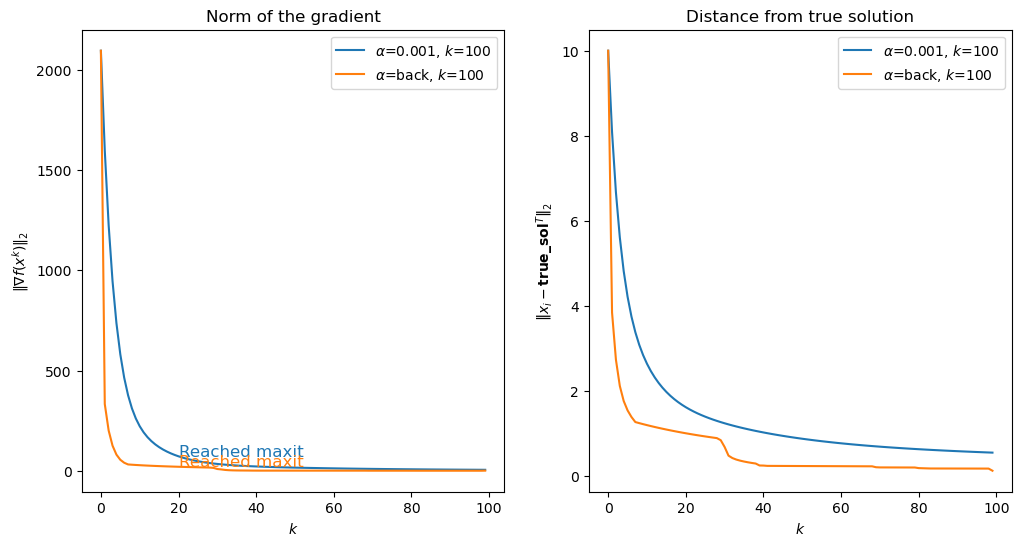

In [6]:
for n in [5,10,20,50,100]:
    print("n = ",n)
    v = np.linspace(0,1,n)
    A = np.vander(v)
    x_true = np.ones((1,n)).T
    b = A @ x_true

    def f(x):
        return (norm(A @ x - b,2) ** 2)/2

    def grad_f(x):
        M = A @ x - b.T
        return (M @ A).T

    x0 = np.zeros((n,))
    exercise_f(f,grad_f,x0=x0,true_sol=x_true,dimensions=n)

--------------------------------


### **Function 4**

$f : \mathbb{R}^n → \mathbb{R}$ such that:

$$ f (x) = \frac{1}{2} \lVert Ax − b \rVert _2^2 + \frac{\lambda}{2} \lVert x \rVert _2^2$$

where $A$ and $b$ are the same of the exercise above, while $\lambda$ is a fixed value in the interval $[0, 1]$.
Try different values for $\lambda$.

lam =  0


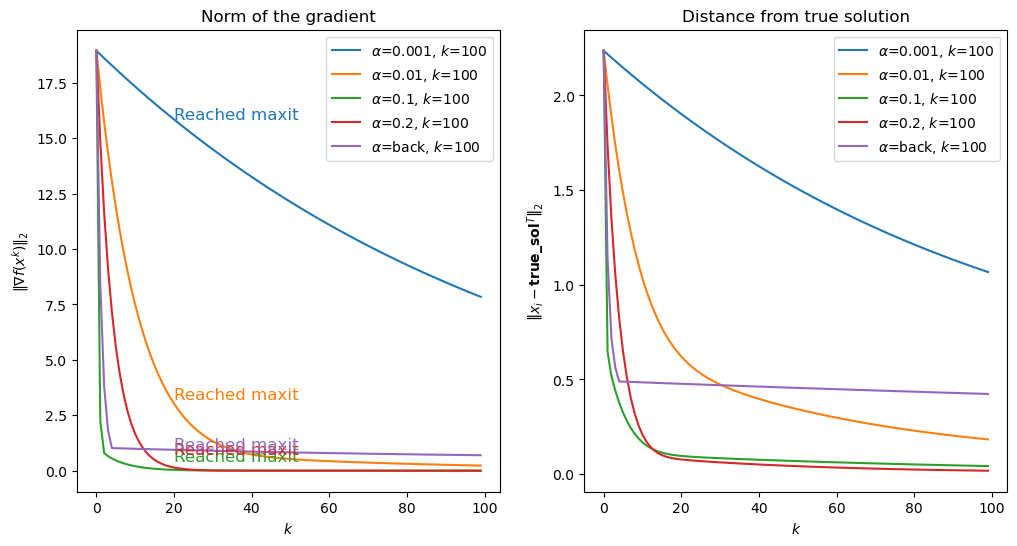

lam =  0.1


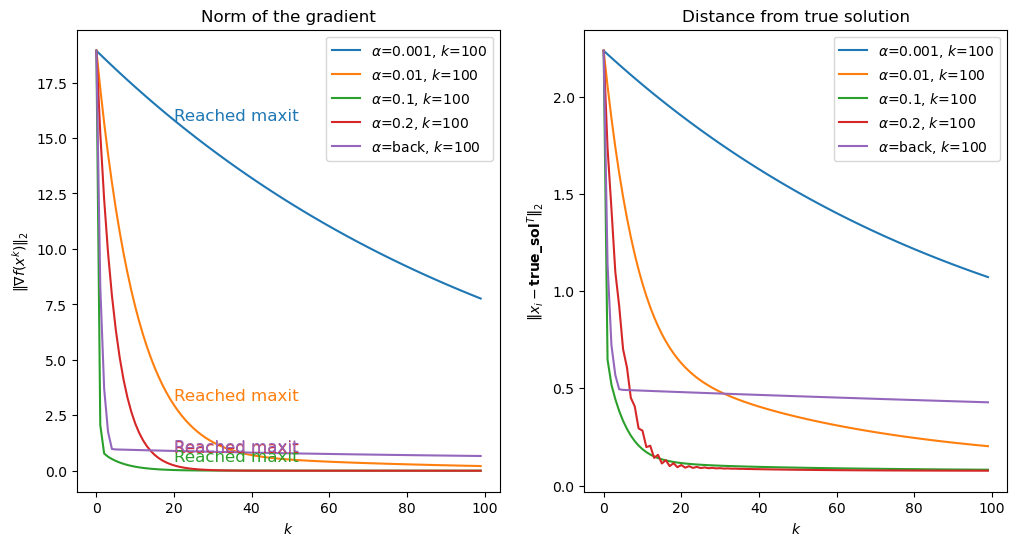

lam =  0.4


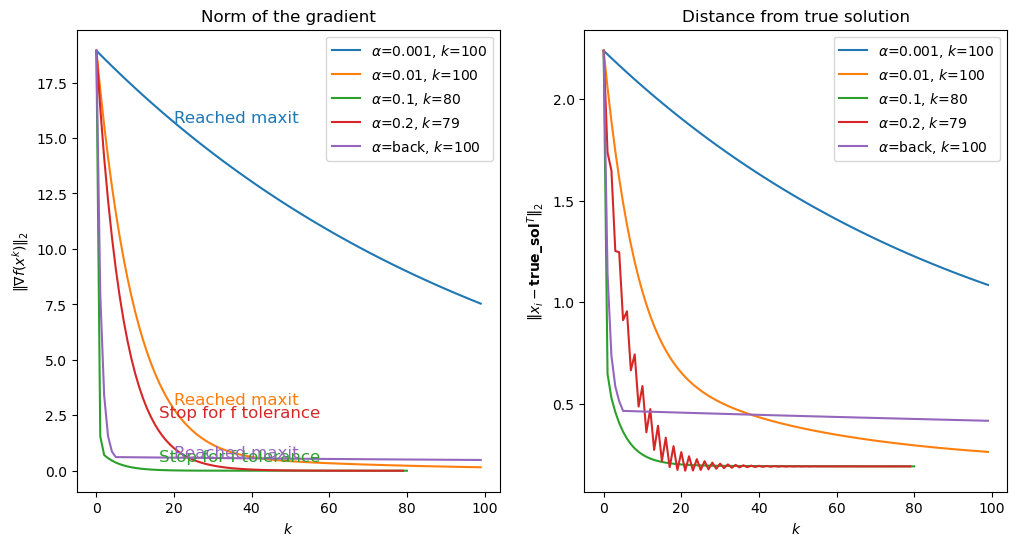

lam =  0.8


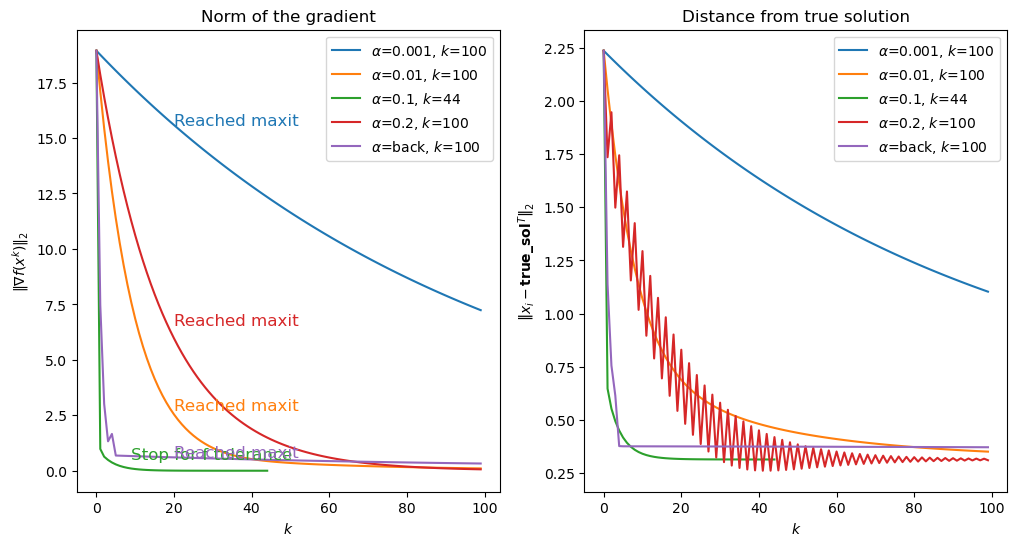

lam =  1


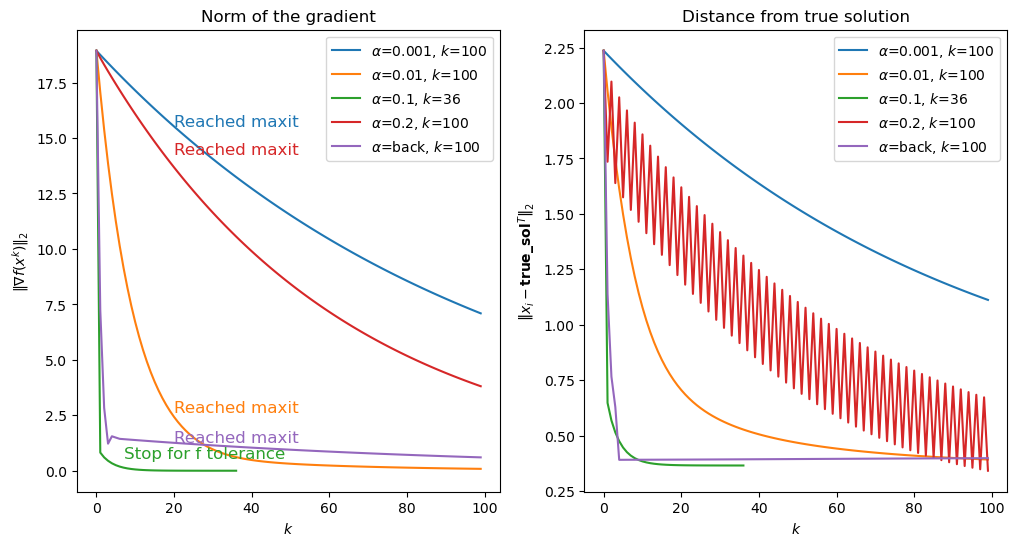

In [7]:
for l in [0,0.1,0.4,0.8,1]:
    print("lam = ", l)
    n = 5
    v = np.linspace(0,1,n)
    A = np.vander(v)
    x_true = np.ones((1,n)).T
    b = A @ x_true
    x0 = np.zeros((n,))

    def f(x,lam=l):
        return (norm(A @ x - b,2) ** 2)/2 + (lam * norm(x,2)**2 / 2)

    def grad_f(x,lam=l):
        M = A @ x - b.T
        return (M @ A).T + lam*x.reshape((n,1))

    exercise_f(f,grad_f,x0=x0,true_sol=x_true,dimensions=n )

-------------

### **Function 5**

$f : \mathbb{R} → \mathbb{R}$ such that:

$$f (x) = x^4 + x^3 − 2x^2 − 2x $$

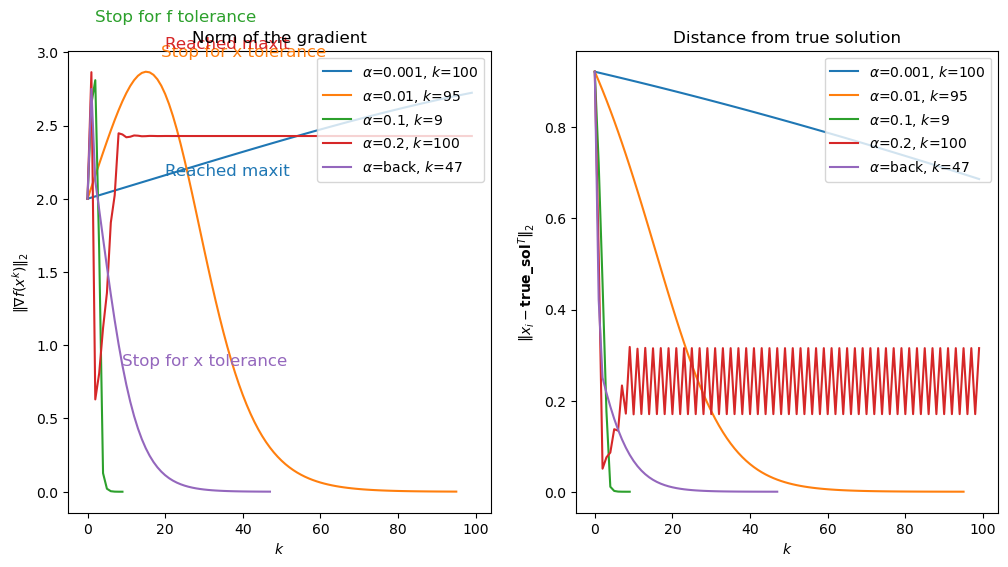

In [8]:
def f(x):
    return x**4 + x**3 - 2*x**2 - 2*x

def grad_f(x):
    return np.array([4*x**3 + 3*x**2 - 4*x - 2])

x0=np.array([0])
# Best value computed
true_sol = np.array([0.9222247929324218857020815]) 
exercise_f(f,grad_f,x0=x0,true_sol=true_sol, dimensions=1)

alpha =  0.001


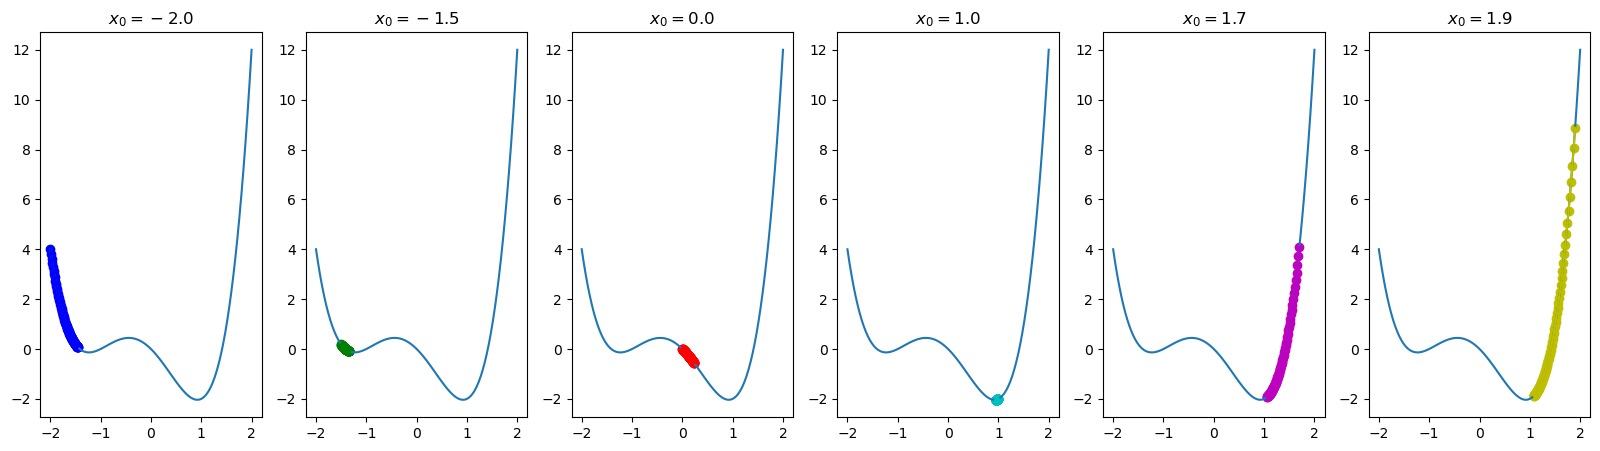

alpha =  0.01


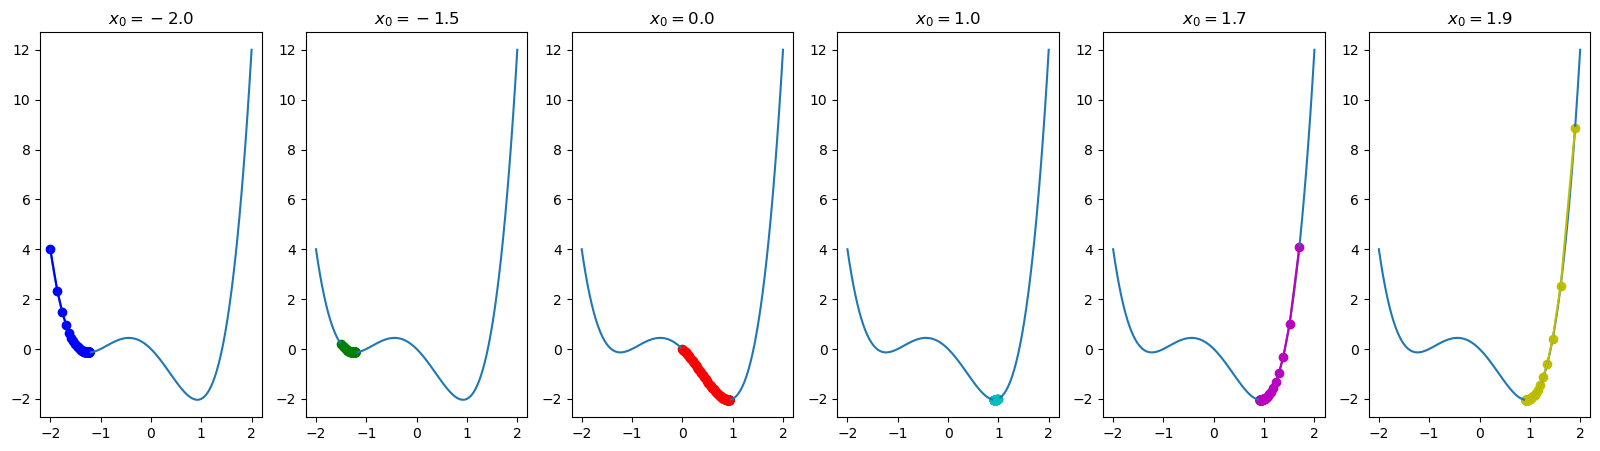

alpha =  0.1


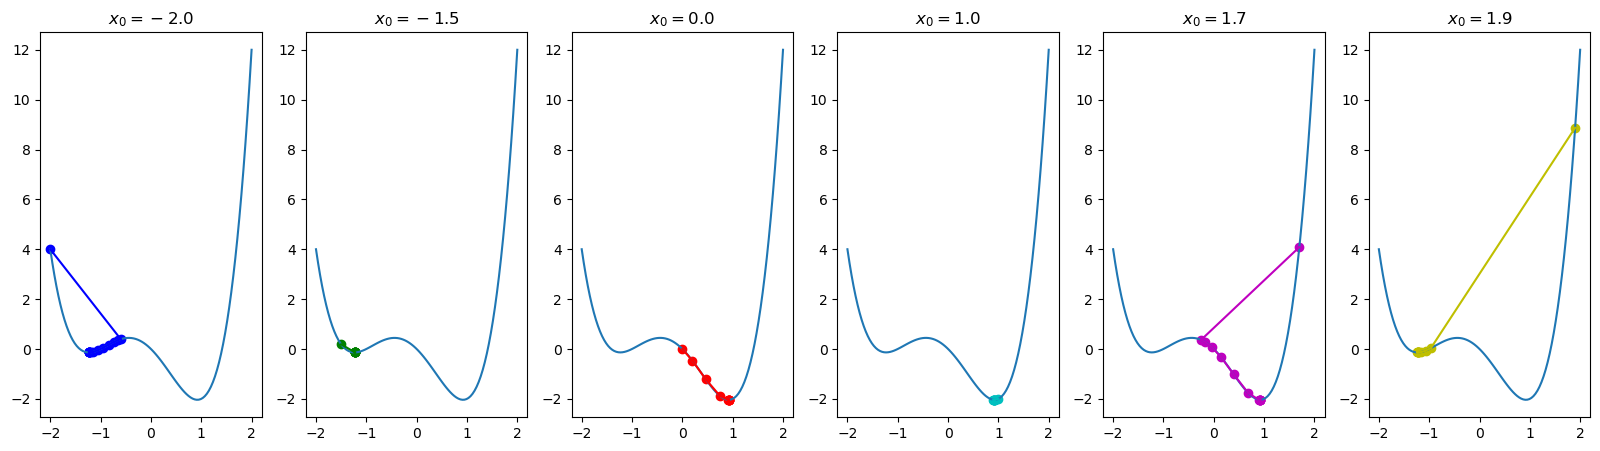

alpha =  0.2


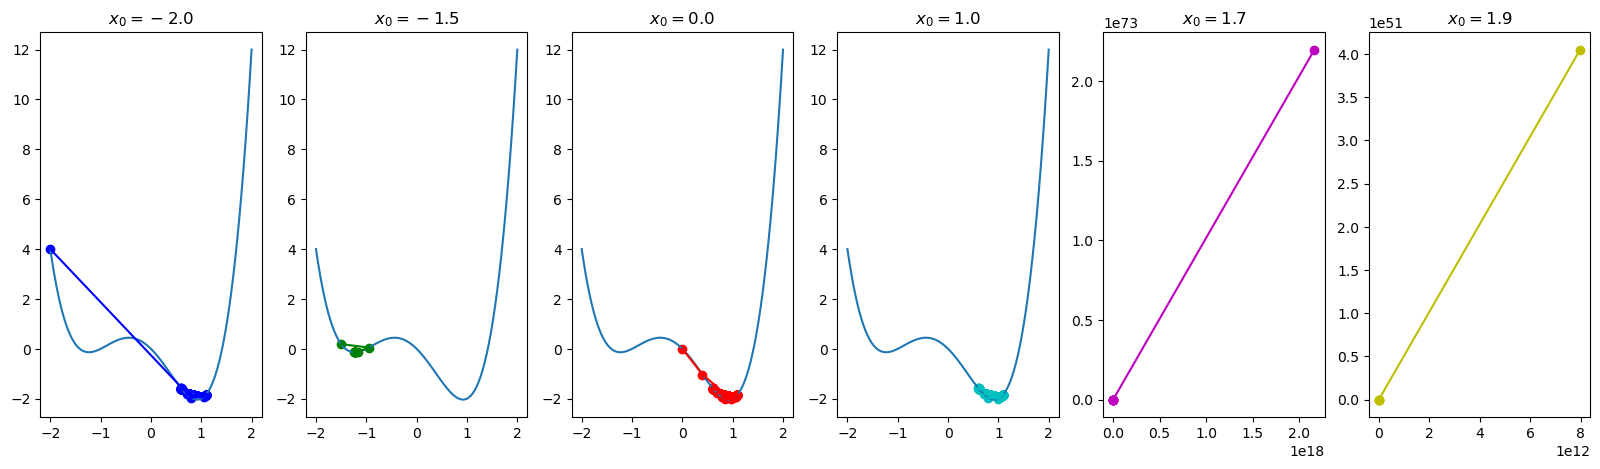

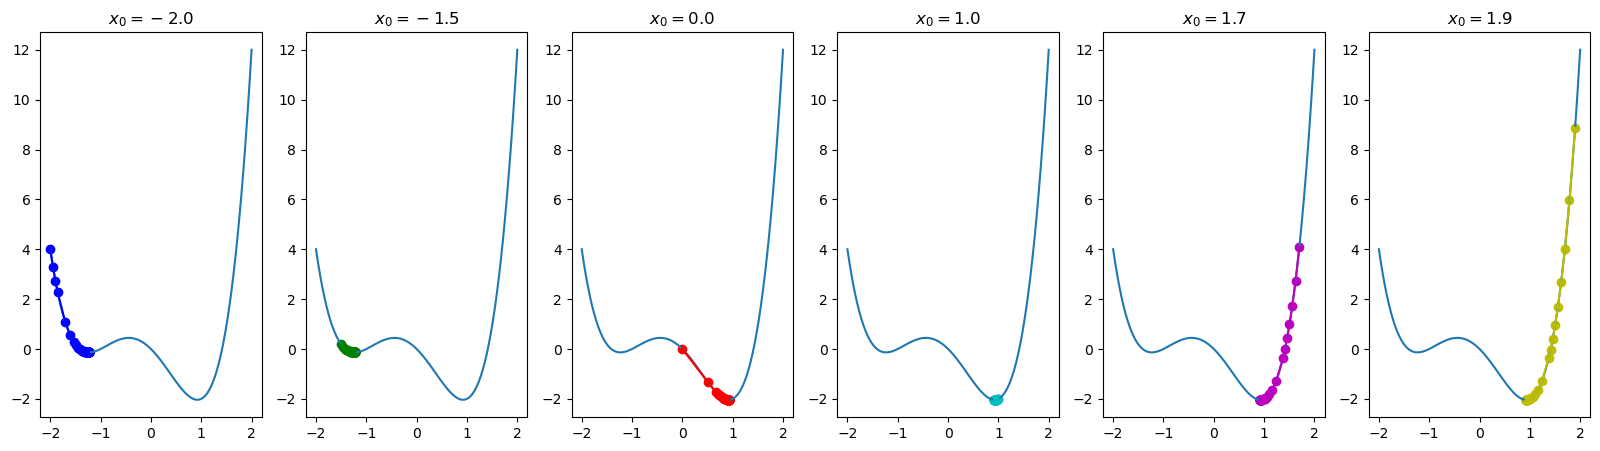

In [9]:
def f(x):
    return x**4 + x**3 - 2*x**2 - 2*x

def grad_f(x):
    return np.array([4*x**3 + 3*x**2 - 4*x - 2])

def plot_f(x0,alpha = None):
    plt.figure(figsize=(20,5))
    colors = ['b','g','r','c','m','y']
    n_x=len(x0)
    for i in range(n_x):
        plt.subplot(1,n_x,i+1)
        xx = np.linspace(-2,2,100)
        plt.plot(xx,f(xx))
        plt.title(f"$x_0 = {x0[i]}$")

        # Calling the GD starting from x0
        if alpha is None:
            x,k,fval,grads,err, converge, message = GD(f,grad_f,np.array([x0[i]]),maxit=100,back_flag=True)
        else:
            x,k,fval,grads,err, converge, message = GD(f,grad_f,np.array([x0[i]]),maxit=100,alpha=alpha)
        x = np.array(x).flatten()
        plt.scatter(x,f(x),c=colors[i % len(colors)])
        for j in range(len(x)-1):
            plt.plot([x[j],x[j+1]],[f(x[j]),f(x[j+1])],c=colors[i % len(colors)])
    plt.show()
x0 = np.array([-2,-1.5,0,1,1.7, 1.9])
for alpha in [0.001,0.01,0.1,0.2]:
    print("alpha = ",alpha)
    plot_f(x0, alpha)
plot_f(x0)